In [25]:
import tweepy
import json
import re
import arrow
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
from dateutil.parser import parse
from textblob import TextBlob
from xml.sax.saxutils import unescape
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

stop_words = stopwords.words("english")
spc = spacy.load('en')

In [85]:
trump = pd.read_csv('trump_clustered_new.csv')
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,tb_subjectivity,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation,k_cluster,a_cluster
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.825000,negative,subjective,0.373,0.627,0.000,-0.8786,negative,24,0
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.750000,positive,subjective,0.205,0.671,0.123,-0.4168,negative,24,0
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,0.397222,positive,objective,0.072,0.740,0.189,0.6885,positive,12,0
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.633333,positive,subjective,0.046,0.640,0.314,0.9439,positive,24,0
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,0.400000,positive,objective,0.000,1.000,0.000,0.0000,neutral,24,0


In [86]:
trump['orientation'] = np.where(trump['tb_orientation'] == trump['vd_orientation'], trump['tb_orientation'], np.nan)

In [87]:
labelled = trump[trump['orientation'].notna()]
unlabelled = trump[trump['orientation'].isna()]
print(trump.shape)
print(labelled.shape)
print(unlabelled.shape)

(4739, 29)
(3257, 29)
(1482, 29)


In [17]:
def clean_text(df)  :
    # remove hyperlinks / digits / accounts
    regex = r'(@[A-Za-z0-9]+)|(&amp;)|(\w+:\/\/\S+)|([A-Za-z]+[\d@]+[\w@]*|[\d@]+[A-Za-z]+[\w@]*)|(\d+\s)|(\s\d+\s)$'
    text_cleaned = df['text'].apply(lambda t: ' '.join(i for i in re.sub(regex, ' ', t).split() if i not in stop_words))
    return pd.concat([df['orientation'], text_cleaned], axis=1)

In [18]:
labelled = clean_text(labelled)
unlabelled = clean_text(unlabelled)

In [19]:
tokenizer = Tokenizer(num_words = 280, oov_token='<OOV>')

# create a 'word_index' dictionary based on word frequency
tokenizer.fit_on_texts(labelled['text'])

# replace words with corresponding integer values from 'word_index' dictionary
train_seq = tokenizer.texts_to_sequences(labelled['text'])

# pad the values so they have equal lengths to form a tensor
train_padded = pad_sequences(train_seq, maxlen=280, padding='post', truncating='post')

In [20]:
# convert orientation labels to integers
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labelled['orientation'])
train_label_seq = np.array(label_tokenizer.texts_to_sequences(labelled['orientation'])) - 1

# one-hot encoding 
train_label = tf.keras.utils.to_categorical(train_label_seq, num_classes=3)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_label, 
                                                  test_size = 0.2, stratify=train_label)

In [22]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(280, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
num_epochs = 10
history = model.fit(X_train, y_train, epochs=num_epochs, 
                    validation_data=(X_val, y_val), verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2605 samples, validate on 652 samples
Epoch 1/10
2605/2605 - 32s - loss: 0.7993 - accuracy: 0.6587 - val_loss: 0.6890 - val_accuracy: 0.6595
Epoch 2/10
2605/2605 - 36s - loss: 0.5459 - accuracy: 0.7574 - val_loss: 0.4081 - val_accuracy: 0.8206
Epoch 3/10
2605/2605 - 35s - loss: 0.3960 - accuracy: 0.8395 - val_loss: 0.3881 - val_accuracy: 0.8344
Epoch 4/10
2605/2605 - 32s - loss: 0.3597 - accuracy: 0.8545 - val_loss: 0.3975 - val_accuracy: 0.8374
Epoch 5/10
2605/2605 - 34s - loss: 0.3209 - accuracy: 0.8729 - val_loss: 0.3520 - val_accuracy: 0.8558
Epoch 6/10
2605/2605 - 30s - loss: 0.3017 - accuracy: 0.8841 - val_loss: 0.3713 - val_accuracy: 0.8482
Epoch 7/10
2605/2605 - 32s - loss: 0.2896 - accuracy: 0.8852 - val_loss: 0.3630 - val_accuracy: 0.8528
Epoch 8/10
2605/2605 - 33s - loss: 0.2738 - accuracy: 0.8925 - val_loss: 0.3708 - val_accuracy: 0.8512
Epoch 9/10
2605/2605 - 29s - loss: 

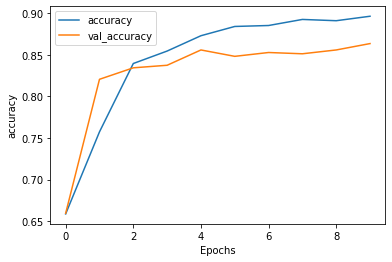

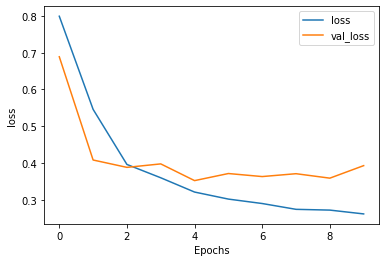

In [24]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
model.save('rnn1')

In [44]:
test_seq = tokenizer.texts_to_sequences(unlabelled['text'])
test_padded = pad_sequences(test_seq, maxlen=280, padding='post', truncating='post')

In [30]:
# result = model.predict(test_padded)
# result = tf.argmax(result, axis=1).numpy()
# result = [[r] for r in (result + 1)]
# result = [t for t in label_tokenizer.sequences_to_texts_generator(result)]

In [52]:
result = model.predict(test_padded)
result

array([[9.9187851e-01, 8.1121624e-03, 9.3753943e-06],
       [9.8426855e-01, 1.5692052e-02, 3.9428018e-05],
       [8.9527410e-01, 2.7387273e-02, 7.7338658e-02],
       ...,
       [2.1874543e-01, 2.1024060e-01, 5.7101399e-01],
       [1.6855945e-01, 8.1795901e-01, 1.3481478e-02],
       [9.9614269e-01, 3.8542661e-03, 3.0588424e-06]], dtype=float32)

In [89]:
result_label = tf.argmax(result, axis=1).numpy()
result_label = [[r] for r in (result_label + 1)]
result_label = np.array([t for t in label_tokenizer.sequences_to_texts_generator(result_label)])
result_label[np.where(np.max(result, axis=1) < 0.9)] = np.nan
result_label

array(['positive', 'positive', 'nan', ..., 'nan', 'nan', 'positive'],
      dtype='<U8')

In [90]:
unlabelled['orientation'] = result_label
unlabelled = unlabelled['orientation']
unlabelled = unlabelled.rename('orientation_rnn') 
unlabelled.head()

/Users/carollam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1     positive
4     positive
10         nan
11         nan
14    negative
Name: orientation_rnn, dtype: object

In [91]:
trump = pd.merge(trump, unlabelled, left_index=True, right_index=True, how='left')
trump['orientation'] = np.where(trump['orientation'].isna(), trump['orientation_rnn'], trump['orientation'])
trump = trump.drop('orientation_rnn', axis=1)
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation,k_cluster,a_cluster,orientation
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,negative,subjective,0.373,0.627,0.000,-0.8786,negative,24,0,negative
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,positive,subjective,0.205,0.671,0.123,-0.4168,negative,24,0,positive
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,positive,objective,0.072,0.740,0.189,0.6885,positive,12,0,positive
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,positive,subjective,0.046,0.640,0.314,0.9439,positive,24,0,positive
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,positive,objective,0.000,1.000,0.000,0.0000,neutral,24,0,positive


In [68]:
trump.to_csv('trump_rnn1.csv', sep=',', encoding='utf-8', index=False)

In [92]:
labelled2 = trump[trump['orientation'] != 'nan']
unlabelled2 = trump[trump['orientation'] == 'nan']
print(trump.shape)
print(labelled2.shape)
print(unlabelled2.shape)

(4739, 29)
(4023, 29)
(716, 29)


In [103]:
labelled2 = clean_text(labelled2)
unlabelled2 = clean_text(unlabelled2)

In [104]:
tokenizer2 = Tokenizer(num_words = 280, oov_token='<OOV>')

# create a 'word_index' dictionary based on word frequency
tokenizer2.fit_on_texts(labelled2['text'])

# replace words with corresponding integer values from 'word_index' dictionary
train_seq2 = tokenizer2.texts_to_sequences(labelled2['text'])

# pad the values so they have equal lengths to form a tensor
train_padded2 = pad_sequences(train_seq2, maxlen=280, padding='post', truncating='post')

In [105]:
# convert orientation labels to integers
label_tokenizer2 = Tokenizer()
label_tokenizer2.fit_on_texts(labelled2['orientation'])
train_label_seq2 = np.array(label_tokenizer2.texts_to_sequences(labelled2['orientation'])) - 1

# one-hot encoding 
train_label2 = tf.keras.utils.to_categorical(train_label_seq2, num_classes=3)

In [106]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(train_padded2, train_label2, 
                                                  test_size = 0.2, stratify=train_label2)

In [107]:
embedding_dim = 64
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(280, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
num_epochs = 10
history2 = model2.fit(X_train2, y_train2, epochs=num_epochs, 
                    validation_data=(X_val2, y_val2), verbose=2)

Train on 3218 samples, validate on 805 samples
Epoch 1/10
3218/3218 - 29s - loss: 0.7376 - accuracy: 0.6809 - val_loss: 0.5951 - val_accuracy: 0.7317
Epoch 2/10
3218/3218 - 34s - loss: 0.4385 - accuracy: 0.8179 - val_loss: 0.4122 - val_accuracy: 0.8273
Epoch 3/10
3218/3218 - 36s - loss: 0.3339 - accuracy: 0.8670 - val_loss: 0.3573 - val_accuracy: 0.8634
Epoch 4/10
3218/3218 - 35s - loss: 0.2903 - accuracy: 0.8931 - val_loss: 0.3608 - val_accuracy: 0.8559
Epoch 5/10
3218/3218 - 34s - loss: 0.2668 - accuracy: 0.8978 - val_loss: 0.3496 - val_accuracy: 0.8596
Epoch 6/10
3218/3218 - 34s - loss: 0.2627 - accuracy: 0.8990 - val_loss: 0.3453 - val_accuracy: 0.8596
Epoch 7/10
3218/3218 - 33s - loss: 0.2470 - accuracy: 0.9071 - val_loss: 0.3428 - val_accuracy: 0.8621
Epoch 8/10
3218/3218 - 33s - loss: 0.2379 - accuracy: 0.9105 - val_loss: 0.3598 - val_accuracy: 0.8547
Epoch 9/10
3218/3218 - 33s - loss: 0.2396 - accuracy: 0.9133 - val_loss: 0.3955 - val_accuracy: 0.8472
Epoch 10/10
3218/3218 - 38